# Numeryczne rozwiązywania równania dyfuzji

In [1]:
using Printf
using GLMakie
using LinearAlgebra
using LaTeXStrings

my_theme = Theme(
               Axis = (
                   xlabelsize = 28, 
                   xticklabelsize = 24, 
                   xminorticks = IntervalsBetween(5), 
                   xminorticksvisible = true, 
                   xgridvisible = false,
                   ylabelsize = 28, 
                   yticklabelsize = 24, 
                   ygridvisible = false, 
                   yminorticks = IntervalsBetween(5), 
                   yminorticksvisible = true,
               ),
               Legend = (
                   labelsize = 24,
               ),
                   palette=(color = cgrad(:managua25, 25, rev=true),),
                   Lines = (cycle = [:color],)
            )
set_theme!(my_theme)


Nasz reaktor będzie składał się z komórek, dla których musimy podać parametry materiału: stałą dyfuzji, przekrój czynny na absporpcję i na rozszczepienie.
Wygodnie będzie zdefiniować strukturę zawierającą takie informacje. 

In [2]:
struct Material
    D::Float64
    Σa::Float64
    νΣf::Float64
end

## Reaktor 1D

Spróbujmy rozwiązać jednowymiarowy problem reaktora taflowego otoczonego reflektorem.

Zacznijmy od zdefiniowania kilku materiałów. Będziemy potrzebować rdzenia, reflektora (np. wody) oraz próżni. Parametry tego typu materiałów pojawiały się na zajęciach i pożyczymy wartości z poprzednich zadań. Natomiast próżnia będzie miała o zerowe przekroje czynne na absorpcję i rozszczepienie oraz bardzo dużą stałą dyfuzji - jest ona odwrotnością przekroju na rozpraszanie, więc dla próżni powinna dążyć do nieskończoności.

In [3]:
core = Material(9.21, 0.153, 0.157)
moderator = Material(6.4, 0.0196, 0.0)
void = Material(1.0e6, 0.0, 0.0)

Material(1.0e6, 0.0, 0.0)

Załóżmy, że grubość reaktora będzie równa $2R_c$, a grubość reflektora $R_r$, z każdej strony (jednostki będą umowne). Układ dodatkowo otoczymy $R_a$ komórkami próżni, tak, aby warunek brzegowy mógł być łagodnie spełniony.

In [4]:
Ra = 2
Rr = 5
Rc = 25
N = 2 * (Ra + Rc + Rr)

reactor = Array{Material, 1}(undef, N)
for i in 1:Ra
    reactor[i] = void
end
for i in Ra+1:Ra+Rr
    reactor[i] = moderator
end
for i in Ra+Rr+1:Ra+Rr+2*Rc
    reactor[i] = core
end
for i in Ra+Rr+2*Rc+1:Ra+Rr+2*Rc+Rr
    reactor[i] = moderator
end
for i in Ra+Rr+2*Rc+Rr+1:N
    reactor[i] = void
end

Sprawdźmy jak wygląda nasz reaktor rysując przekrój czynny na absorpcję.

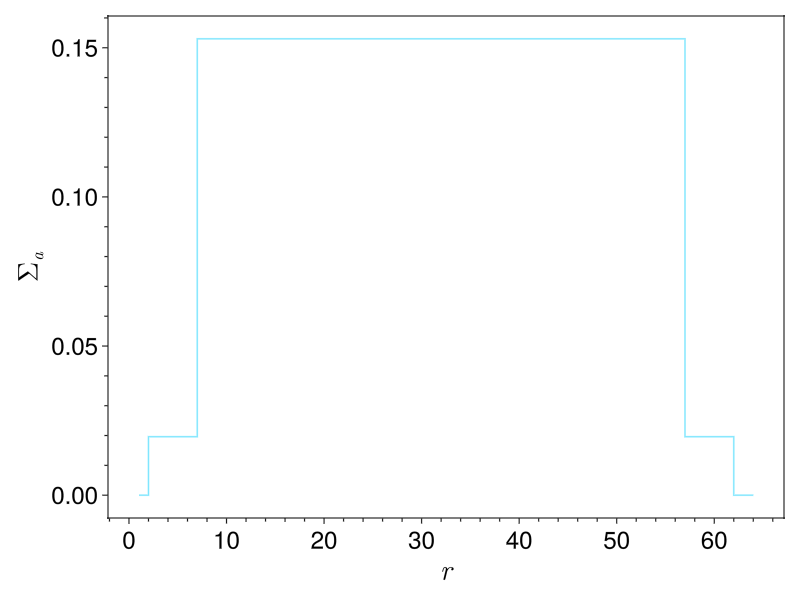

In [5]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1]; xlabel=L"r", ylabel=L"\Sigma_a")
stairs!(ax, [reactor[i].Σa for i in 1:N])
fig

Główna część problemu polega na zaimplementowaniu metody rozwiązywania zagadnienia danego przez macierz `reaktor`. 
Będziemy musieli przejść przez kilka kroków, które pokażemy osobno, ale finalnie zostaną zebrane w jedną funkcję.

Rozwiązaniem naszego problemu będzie strumień neutronów $\Phi$. Musimy zacząć od jakiegoś rozwiązania początkowego, które powinno być w miarę rozsądne (np. wektor samych zer jest złym pomysłem). Im lepiej zgadniemy postać rozwiązania, tym szybciej algorytm zbiegnie do prawidłowego. Prosty pomysł spełniający te warunki to np. wektor zawierający stałą tam, gdzie mamy jakiś materiał rozszczepialny i zera w pozostałych miejscach.

In [6]:
F = zeros(N)
for i in 1:N
    if reactor[i].νΣf > 0.0
        F[i] = 1.0
    end
end

Następny krok to stworzenie macierzy A, o rozmiarze $N\times N$, definującej nasze zdyskretyzowane równiania dyfuzji dla każdego punktu reaktora.

Implementujemy tutaj schemat sprzężeń dla problemu 1D omawiany na ćwiczeniach.

Uwaga o wyrazach A[1] i A[N] - w przypadku warunku brzegowego "próżni", ze względu na brak sąsiadów na zewnątrz, musimy zadbać o brak wpływów z tej strony. Alternatywą jest warunek brzegowy cykliczny (stosowany np. w modelowaniu nieskończonych siatek), wtedy możemy zażądać, aby A[1] było sąsiadem A[N] i odpowiednio zmodyfikować równania.

In [7]:
A = zeros(N, N)
d = 1.0
for i in 1:N
    A[i, i] = reactor[i].Σa + 2 * reactor[i].D / (2 * d^2)
    if i > 1
        A[i, i] += reactor[i-1].D / (2 * d^2)
        A[i, i-1] = -(reactor[i].D + reactor[i-1].D) / (2 * d^2)
    end
    if i < N
        A[i, i] += reactor[i+1].D / (2 * d^2)
        A[i, i+1] = -(reactor[i].D + reactor[i+1].D) / (2 * d^2)
    end
end

Sprawdźmy, jak wygląda macierz A.

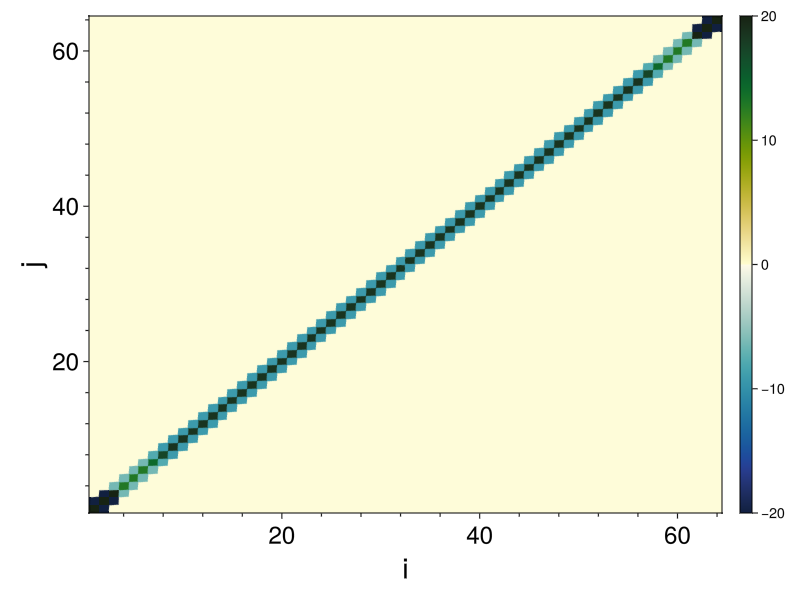

In [8]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1]; xlabel="i", ylabel="j")
hm = heatmap!(ax, A, colormap=:delta, colorrange=(-20, 20))
Colorbar(fig[1, 2], hm)
fig

Potrzebujemy teraz parametru zbieżności rozwiązania ($\lambda$), oraz $\epsilon$ względną różnicę między nową $\lambda_{i+1}$, a poprzednią $\lambda_i$. Ustalmy, że uznajemy rozwiązanie, za zbieżne, gdy epsilon jest mniejszy niż $10^{-6}$.

Na podstawie parametrów reaktora, lambdy oraz wstępnego strumienia policzymy prawą część równania (źródło: $S$).

In [9]:
λ = 1.0
S = 1 / λ .* [reactor[i].νΣf for i in 1:N] .* F
ϵ = 1.0
ϵlim = 1.0e-6

1.0e-6

Jesteśmy gotowi do stworzenia głównej pętli rozwiązania. Dopóki $\epsilon$ - względna zmiana $\lambda_i$ - jest większy niż zadana granica, będziemy powtarzać schemat:
1. Znajdź nowy strumień $\Phi = A^{-1}S$
1. Policz nowe $\lambda_{i+1}$ (suma po wszystkich punktach w prawej części równania z nowym strumieniem, podzielona przez poprzednią wartość)
1. Policz nową prawą cześć równania (dla $\lambda_{i+1}$)
1. Policz względną zmianę lambdy

W Julii do rozwiązania zagadnienia $A\Phi = S$ użyjemy operatora dzielenia macierzowego `\`, który dla operacji A \ B zwraca wynik X, taki, że A * X = B, czyli to o co nam chodzi. Operator ten jest polialgorytmiczny - w zależności od charakteru macierzy sam dobiera właściwą metodę. Dla macierzy górnotrójkątnych stosuje podstawienie wsteczne, dla trójdiagonalnych rozkład LU. O tym jak rozpozna naszą macierz możemy przekonać się wołając funkcję `factorize`, która zwróci najwygodniejszą w danym przypadku postać.

In [10]:
factorize(A)

LU{Float64, Tridiagonal{Float64, Vector{Float64}}, Vector{Int64}}
L factor:
64×64 Matrix{Float64}:
  1.0        0.0        0.0          0.0       …   0.0        0.0       0.0
 -0.666667   1.0        0.0          0.0           0.0        0.0       0.0
  0.0       -0.600002   1.0          0.0           0.0        0.0       0.0
  0.0        0.0       -3.19989e-5   1.0           0.0        0.0       0.0
  0.0        0.0        0.0         -0.499244      0.0        0.0       0.0
  0.0        0.0        0.0          0.0       …   0.0        0.0       0.0
  0.0        0.0        0.0          0.0           0.0        0.0       0.0
  0.0        0.0        0.0          0.0           0.0        0.0       0.0
  0.0        0.0        0.0          0.0           0.0        0.0       0.0
  0.0        0.0        0.0          0.0           0.0        0.0       0.0
  0.0        0.0        0.0          0.0       …   0.0        0.0       0.0
  0.0        0.0        0.0          0.0           0.0        0.0

In [11]:
Sf = [reactor[i].νΣf for i in 1:N]
while ϵ > ϵlim
    Fn = A \ S
    λₙ = sum(Sf .* Fn) / sum(Sf .* F) * λ
    Sn = 1 / λₙ .* Sf .* Fn
    ϵ = abs(λₙ - λ) / λ
    F = copy(Fn)
    S = copy(Sn)
    λ = λₙ
end
@printf("ϵ = %.3e\n", ϵ)

ϵ = 8.338e-07


Dla wygody wektor zawierający wyraz $\nu\Sigma_f$ policzyliśmy przed główną pętlą, aby nie powtarzać zbędnie operacji zbierania tej struktury.

Narysujmy uzyskany strumień.

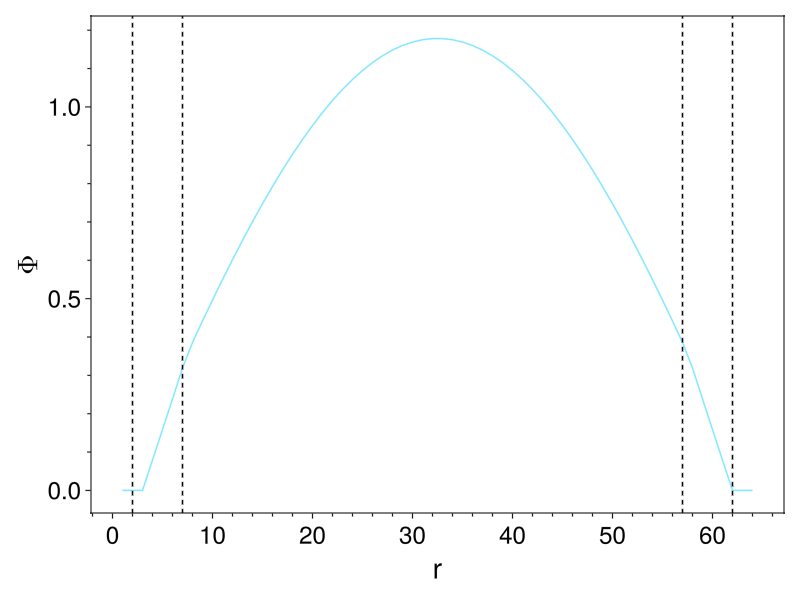

In [12]:
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1]; xlabel="r", ylabel=L"\Phi")
lines!(ax, F)
vlines!(ax, [Ra, Ra+Rr, Ra+Rr+2*Rc, Ra+Rr+2*Rc+Rr], color=:black, linestyle=:dash)
fig

Możemy sprawdzić też jak wyglądają kolejne przybliżenia, rysując strumień w pętli dla kolejnych przybliżeń.

i = 1, ϵ = 1.490e-01
i = 2, ϵ = 2.737e-02
i = 3, ϵ = 9.871e-03
i = 4, ϵ = 4.155e-03
i = 5, ϵ = 1.852e-03
i = 6, ϵ = 8.446e-04
i = 7, ϵ = 3.890e-04
i = 8, ϵ = 1.799e-04
i = 9, ϵ = 8.340e-05
i = 10, ϵ = 3.869e-05
i = 11, ϵ = 1.796e-05
i = 12, ϵ = 8.335e-06
i = 13, ϵ = 3.869e-06
i = 14, ϵ = 1.796e-06
i = 15, ϵ = 8.338e-07


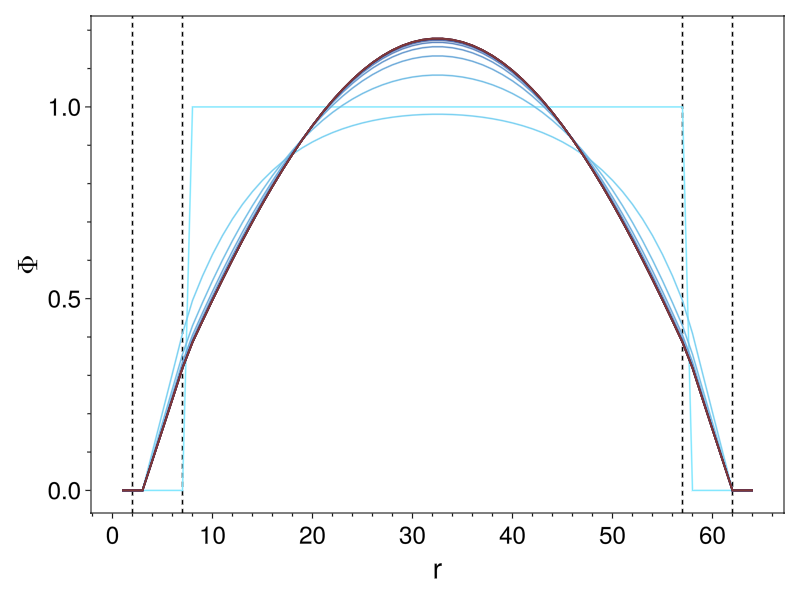

In [14]:
F = zeros(N)
for i in 1:N
    if reactor[i].νΣf > 0.0
        F[i] = 1.0
    end
end

λ = 1.0
S = 1 / λ .* [reactor[i].νΣf for i in 1:N] .* F
ϵ = 1.0
ϵlim = 1.0e-6
i = 1
Sf = [reactor[i].νΣf for i in 1:N]

fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1]; xlabel="r", ylabel=L"\Phi")
vlines!(ax, [Ra, Ra+Rr, Ra+Rr+2*Rc, Ra+Rr+2*Rc+Rr], color=:black, linestyle=:dash)

while ϵ > ϵlim
    lines!(ax, F)
    Fn = A \ S
    λₙ = sum(Sf .* Fn) / sum(Sf .* F) * λ
    Sn = 1 / λₙ .* Sf .* Fn
    ϵ = abs(λₙ - λ) / λ
    F = copy(Fn)
    S = copy(Sn)
    λ = λₙ
    @printf("i = %d, ϵ = %.3e\n", i, ϵ)
    i += 1

end
lines!(ax, F)
fig

Wreszcie naszą metodę można zebrać do funkcji, która będzie uniwersalna dla problemów 1D.

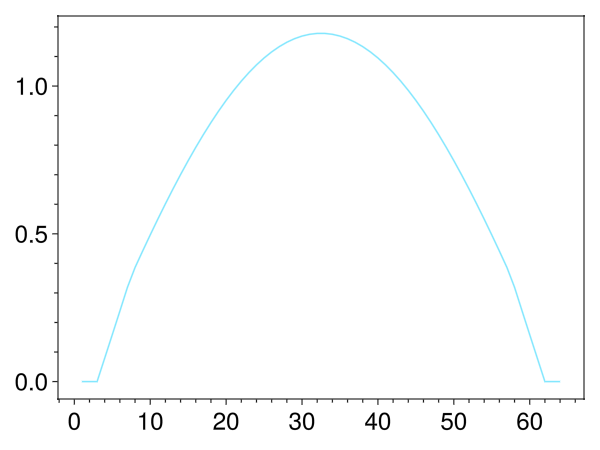

In [15]:
function solve1d(reactor; ϵlim=1e-6)
    N = length(reactor)
    F = zeros(N)
    for i in 1:N
        if reactor[i].νΣf > 0.0
            F[i] = 1.0
        end
    end

    λ = 1.0
    S = 1 / λ .* [reactor[i].νΣf for i in 1:N] .* F
    ϵ = 1.0
    Sf = [reactor[i].νΣf for i in 1:N]

    while ϵ > ϵlim
        Fn = A \ S
        λn = sum(Sf .* Fn) / sum(Sf .* F) * λ
        Sn = 1 / λn .* Sf .* Fn
        ϵ = abs(λn - λ) / λ
        F = copy(Fn)
        S = copy(Sn)
        λ = λn
    end
    F
end

F = solve1d(reactor)
lines(F)

## Reaktor 2D

W przypadku reaktora dwuwymiarowego nasze komórki ustawiamy w wektorze jednowymiarowym (odpowiednio definiując indeks), 
tak aby macierz A nadal była dwuwymiarowa - z tym, że jej wymiar będzie teraz $N^2 \times N^2$. Najwygodniej będzie stworzyć funkcję obliczającą taki indeks z danych położenia komórki $(i, j)$.

Będziemy musimy zmodyfikować macierz opisującą problem - pojawią się wyrazy dające sprzężenia z sąsiadami "z góry" i "z dołu", oprócz prawego i lewego, których mieliśmy w zagadnieniu 1D.

Uwaga - Julia stosuje porządek macierzy kolumnowy i nasze indeksowanie ustawimy zgodnie z tą logiką. Podobnie, iteracja po pętlach powinna najpierw używać indeksu kolumny, a potem wiersza. W językach jak C czy Python, stosowany jest porządek wierszowy.

In [16]:
reshape(1:9, 3, 3)

3×3 reshape(::UnitRange{Int64}, 3, 3) with eltype Int64:
 1  4  7
 2  5  8
 3  6  9

Pierwszy indeks to rząd, drugi kolumna, a zatem funkcja zwracająca indeks będzie miała postać następującą (pod spodem test naszego indeksowania)

In [17]:
function k_index(i, j, N)
    i + (j - 1) * N
end

for i in 1:3
    for j in 1:3
        @printf("(%d,%d)->%d  ", i, j, k_index(i, j, 3))
    end
    println()
end
println()

(1,1)->1  (1,2)->4  (1,3)->7  
(2,1)->2  (2,2)->5  (2,3)->8  
(3,1)->3  (3,2)->6  (3,3)->9  



Zaczniemy od stworzenia reaktora. Ponownie spróbujemy rozwiązać problem z reflektorem, tym razem jednak reaktor będzie miał przekrój kołowy.

In [18]:
Ra = 2
Rr = 5
Rc = 25
N = 2 * (Ra + Rr + Rc + 1)

reactor2 = Array{Material, 2}(undef, N, N)
for j in 1:N, i in 1:N
    r = sqrt((i - N/2)^2 + (j - N/2)^2)
    if r > Rr + Rc
        reactor2[i, j] = void
    elseif Rr + Rc >= r > Rc
        reactor2[i, j] = moderator
    else 
        reactor2[i, j] = core
    end
end

Znowu sprawdzimy jak wygląda nasz reaktor patrząc na $\Sigma_a$

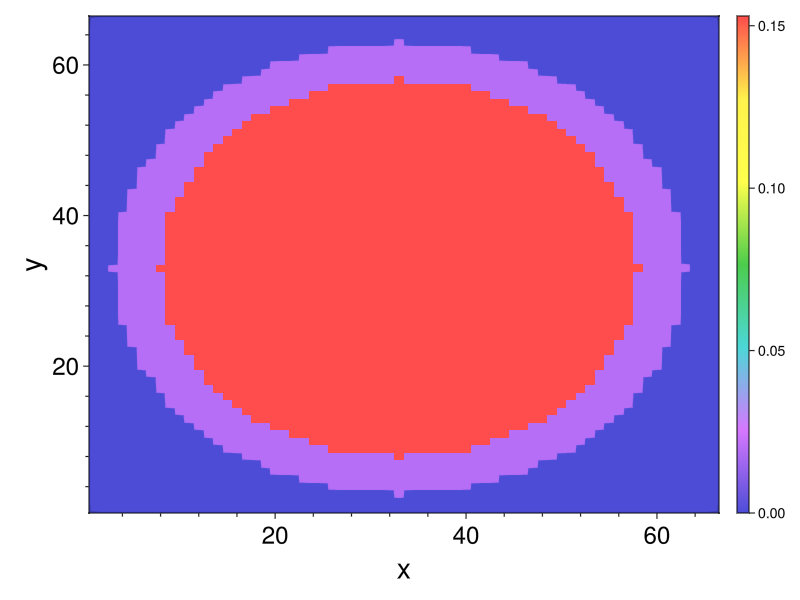

In [19]:
fig = Figure(size=(800, 600))
Sa = zeros(N, N)
for j in 1:N, i in 1:N
    Sa[i, j] = reactor2[i, j].Σa
end
ax = Axis(fig[1, 1]; xlabel="x", ylabel="y")
hm = heatmap!(ax, Sa, colormap=:lighttest)
Colorbar(fig[1, 2], hm)
fig

Rozwiązywanie znowu zaczniemy od wstępnego rozwiązania, które jak poprzednio będzie zawierać jedynki dla obszaru rdzenia i zera dla pozostałych

In [20]:
F = zeros(N, N)
for j in 1:N, i in 1:N
    if reactor2[i, j].νΣf > 0
        F[i, j] = 1.0
    end
end

Tworzymy teraz macierz A, która będzie definiować sprzężenia między komórkami. Ponieważ komórek jest $N^2$, a macierz musi podawać współczynniki dla dowolnej pary, będzie miała rozmiar $N^2\times N^2$. 

Wypełniamy ją wartościami zgodnie ze schematem dla problemów 2D. Dla każdej komórki $k$ liczymy indeks sąsiadów góra/dół/lewo/prawo - odpowiednio $k_u, k_d, k_l, k_r$. Tak jak poprzednio musimy zadbać o przypadki bez danych sąsiadów.

In [21]:
A = zeros(N^2, N^2)
for j in 1:N, i in 1:N
    k = k_index(i, j, N)
    ku = k_index(i - 1, j, N)
    kd = k_index(i + 1, j, N)
    kl = k_index(i, j - 1, N)
    kr = k_index(i, j + 1, N)
    A[k, k] = reactor2[k].Σa + 2 * reactor2[k].D / d^2
    if j > 1
        A[k, kl] -= (reactor2[k].D + reactor2[kl].D) / (2 * d^2)
        A[k, k] += reactor2[kl].D / (2 * d^2)
    end
    if j < N
        A[k, kr] -= (reactor2[k].D + reactor2[kr].D) / (2 * d^2)
        A[k, k] += reactor2[kr].D / (2 * d^2)
    end
    if i > 1
        A[k, ku] -= (reactor2[k].D + reactor2[ku].D) / (2 * d^2)
        A[k, k] += reactor2[ku].D / (2 * d^2)
    end
    if i < N
        A[k, kd] -= (reactor2[k].D + reactor2[kd].D) / (2 * d^2)
        A[k, k] += reactor2[kd].D / (2 * d^2)
    end
end


Sprawdzamy postać macierzy A, ponieważ jest ona dość duża i w większości pusta, po prawiej stronie
powiększenie obszaru 1-100.

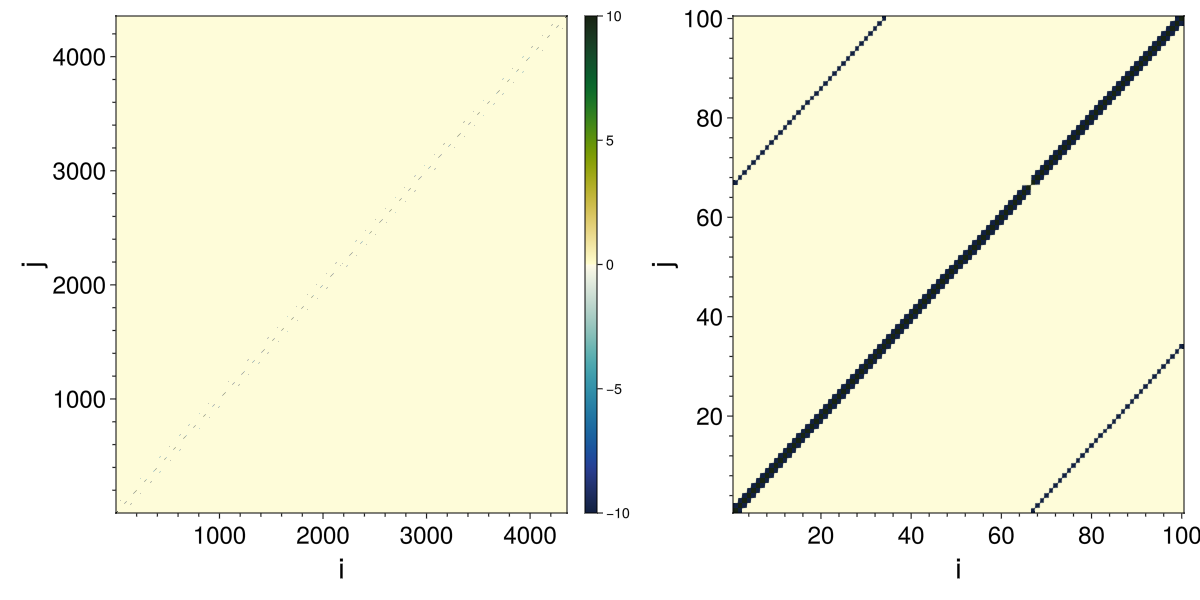

In [22]:
fig = Figure(size=(1200, 600))
ax = Axis(fig[1, 1]; xlabel="i", ylabel="j")
hm = heatmap!(ax, A, colormap=:delta, colorrange=(-10, 10))
Colorbar(fig[1, 2], hm)

ax2 = Axis(fig[1, 3]; xlabel="i", ylabel="j")
heatmap!(ax2, A[1:100, 1:100], colormap=:delta, colorrange=(-10, 10))
fig

Z ciekawości możemy sprawdzić jaki algorytm będzie zastosowany do tej macierzy, która ma teraz 5 diagonalii.

In [23]:
factorize(A)

Cholesky{Float64, Matrix{Float64}}
U factor:
4356×4356 UpperTriangular{Float64, Matrix{Float64}}:
 1732.05  -577.35     0.0       0.0    …     0.0         0.0         0.0
     ⋅    1779.51  -561.951     0.0          0.0         0.0         0.0
     ⋅        ⋅    1784.44   -560.401        0.0         0.0         0.0
     ⋅        ⋅        ⋅     1784.92         0.0         0.0         0.0
     ⋅        ⋅        ⋅         ⋅           0.0         0.0         0.0
     ⋅        ⋅        ⋅         ⋅     …     0.0         0.0         0.0
     ⋅        ⋅        ⋅         ⋅           0.0         0.0         0.0
     ⋅        ⋅        ⋅         ⋅           0.0         0.0         0.0
     ⋅        ⋅        ⋅         ⋅           0.0         0.0         0.0
     ⋅        ⋅        ⋅         ⋅           0.0         0.0         0.0
     ⋅        ⋅        ⋅         ⋅     …     0.0         0.0         0.0
     ⋅        ⋅        ⋅         ⋅           0.0         0.0         0.0
     ⋅        ⋅        ⋅  

Algorytm wybrał rozkład Choleskiego ($A = LL^T$), który jest możliwy dla macierzy symetrycznej i dodatnio określonej. Jest on około dwa razy bardziej wydajny niż jeszcze ogólniejszy przypadek rozkładu LU.

Jeżeli nasz początkowy strumień zamienimy na jednowymiarowy wektor, to zasadniczo pozostała część rozwiązania numerycznego powinna działać tak samo - definicja zagadnienia kryje się w macierzy A.

In [24]:
F = reshape(F, N^2)

Sf = [reactor2[i].νΣf for i in eachindex(reactor2)]
λ = 1.0
S = 1 / λ .* Sf .* F
ϵ = 1.0

while ϵ > ϵlim
    Fn = A \ S
    λn = sum(Sf .* Fn) / sum(Sf .* F) * λ
    Sn = 1 / λn .* Sf .* Fn
    ϵ = abs(λn - λ) / λ
    F = copy(Fn)
    S = copy(Sn)
    λ = λn
end
@printf("%.3e\n", ϵ)

7.729e-07


Jeżeli chcemy narysować mapę strumienia wystarczy po rozwiązaniu wrócić do postaci $N\times N$. Warto zwrócić uwagę, że reinterpretacja macierzy do innego kształtu zasadniczo nic nie kosztuje - elementy macierzy są i tak ułożone w pamięci w sposób liniowy.

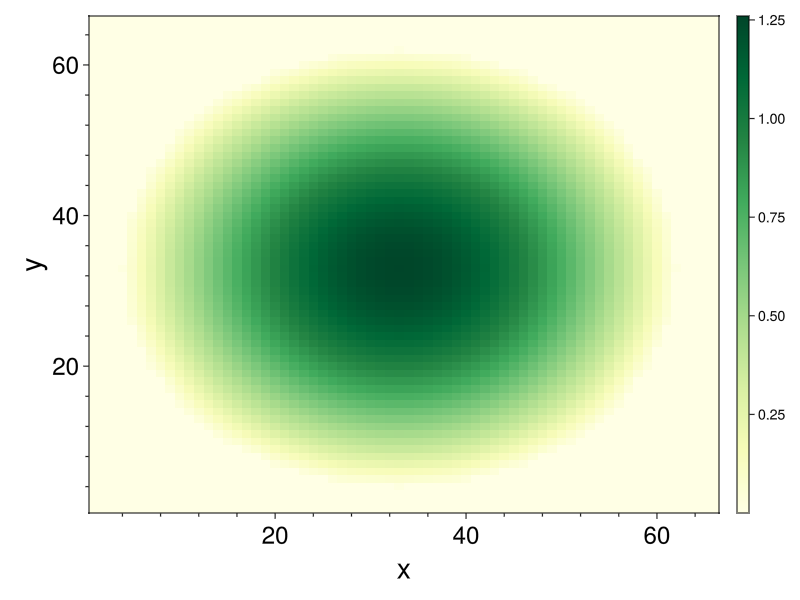

In [25]:
F = reshape(F, N, N)
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1]; xlabel="x", ylabel="y")
hm = heatmap!(ax, F, colormap=:YlGn)
Colorbar(fig[1, 2], hm)
fig

Aby lepiej zrozumieć kształt rozwiązania, narysujemy przekroje wzdłuż wybranych osi X $(0, R_c/2, Rc)$. 

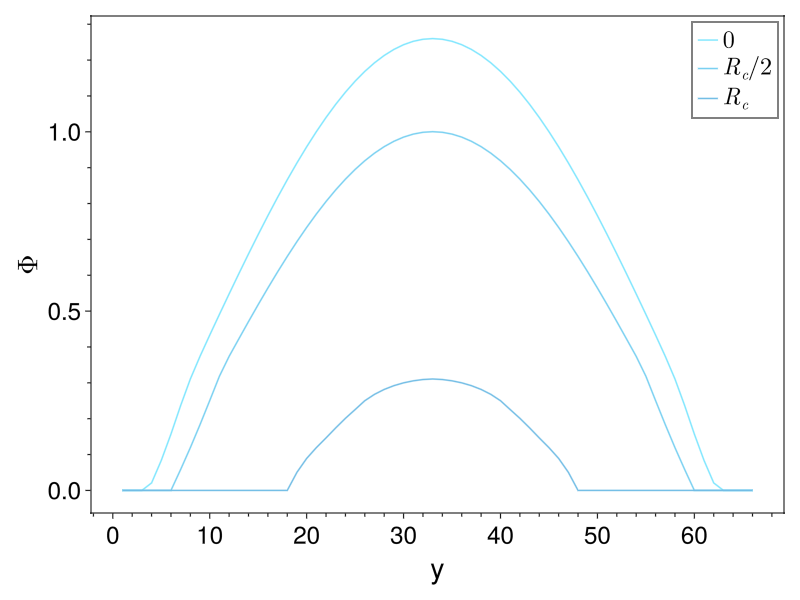

In [26]:
x0 = round(Int, N/2)
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1]; xlabel="y", ylabel=L"\Phi")
lines!(ax, F[x0, :], label=L"0")
lines!(ax, F[x0-round(Int, Rc/2), :], label=L"R_c / 2")
lines!(ax, F[x0-Rc, :], label=L"R_c")
axislegend(ax)

fig

Jak poprzednio naszą metodę możemy zebrać do jednej funkcji.

In [27]:
function solve2d(reactor2; ϵlim=1.0e-6)
    N = size(reactor2)[1]
    F = zeros(N, N)
    for j in 1:N, i in 1:N
        if reactor2[i, j].νΣf > 0
            F[i, j] = 1.0
        end
    end
    
    A = zeros(N^2, N^2)
    for j in 1:N, i in 1:N
        k = k_index(i, j, N)
        ku = k_index(i - 1, j, N)
        kd = k_index(i + 1, j, N)
        kl = k_index(i, j - 1, N)
        kr = k_index(i, j + 1, N)
        A[k, k] = reactor2[k].Σa + 2 * reactor2[k].D / d^2
        if j > 1
            A[k, kl] -= (reactor2[k].D + reactor2[kl].D) / (2 * d^2)
            A[k, k] += reactor2[kl].D / (2 * d^2)
        end
        if j < N
            A[k, kr] -= (reactor2[k].D + reactor2[kr].D) / (2 * d^2)
            A[k, k] += reactor2[kr].D / (2 * d^2)
        end
        if i > 1
            A[k, ku] -= (reactor2[k].D + reactor2[ku].D) / (2 * d^2)
            A[k, k] += reactor2[ku].D / (2 * d^2)
        end
        if i < N
            A[k, kd] -= (reactor2[k].D + reactor2[kd].D) / (2 * d^2)
            A[k, k] += reactor2[kd].D / (2 * d^2)
        end
    end
    
    F = reshape(F, N^2)
    Sf = [reactor2[i].νΣf for i in eachindex(reactor2)]
    λ = 1.0
    S = 1 / λ .* Sf .* F
    ϵ = 1.0

    while ϵ > ϵlim
        Fn = A \ S
        λn = sum(Sf .* Fn) / sum(Sf .* F) * λ
        Sn = 1 / λn .* Sf .* Fn
        ϵ = abs(λn - λ) / λ
        F = copy(Fn)
        S = copy(Sn)
        λ = λn
    end
    reshape(F, N, N)
end

solve2d (generic function with 1 method)

Sprawdźmy teraz jak wygląda rozwiązanie dla reaktora bez reflektora (powiększamy Ra kosztem Rr, aby zachować ten sam rozmiar)

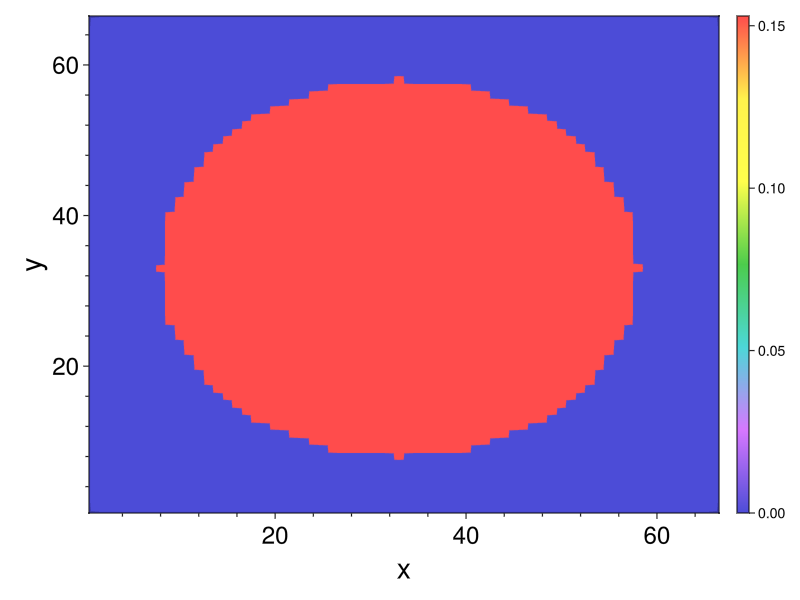

In [28]:
Ra = 7
Rr = 0
Rc = 25
N = 2 * (Ra + Rr + Rc + 1)

reactor2b = Array{Material, 2}(undef, N, N)
for j in 1:N, i in 1:N
    r = sqrt((i - N/2)^2 + (j - N/2)^2)
    if r > Rr + Rc
        reactor2b[i, j] = void
    elseif Rr + Rc >= r > Rc
        reactor2b[i, j] = moderator
    else 
        reactor2b[i, j] = core
    end
end

fig = Figure(size=(800, 600))
Sa = zeros(N, N)
for j in 1:N, i in 1:N
    Sa[i, j] = reactor2b[i, j].Σa
end
ax = Axis(fig[1, 1]; xlabel="x", ylabel="y")
hm = heatmap!(ax, Sa, colormap=:lighttest)
Colorbar(fig[1, 2], hm)
fig

In [29]:
F1 = solve2d(reactor2)
F2 = solve2d(reactor2b)

66×66 Matrix{Float64}:
 1.08021e-7  1.62032e-7  2.16041e-7  …  2.09362e-7  1.57015e-7  1.04674e-7
 1.62032e-7  2.4305e-7   3.24068e-7     3.1404e-7   2.35518e-7  1.57006e-7
 2.16041e-7  3.24068e-7  4.32101e-7     4.18711e-7  3.14011e-7  2.0933e-7
 2.70043e-7  4.05079e-7  5.40134e-7     5.23363e-7  3.92484e-7  2.61638e-7
 3.2403e-7   4.86073e-7  6.48153e-7     6.27981e-7  4.70922e-7  3.1392e-7
 3.77988e-7  5.6703e-7   7.56137e-7  …  7.32536e-7  5.49304e-7  3.66161e-7
 4.31898e-7  6.47922e-7  8.64049e-7     8.3699e-7   6.27599e-7  4.18337e-7
 4.85734e-7  7.28712e-7  9.71844e-7     9.41293e-7  7.05764e-7  4.70421e-7
 5.39458e-7  8.09346e-7  1.07946e-6     1.04537e-6  7.83743e-7  5.22373e-7
 5.93023e-7  8.89757e-7  1.18681e-6     1.14914e-6  8.61461e-7  5.7414e-7
 6.46365e-7  9.69854e-7  1.29378e-6  …  1.25247e-6  9.38823e-7  6.25658e-7
 6.994e-7    1.04952e-6  1.40023e-6     1.35521e-6  1.0157e-6   6.76838e-7
 7.52019e-7  1.12859e-6  1.50596e-6     1.45716e-6  1.09194e-6  7.27571e-7
 ⋮   

4.602e+01 4.673e+01


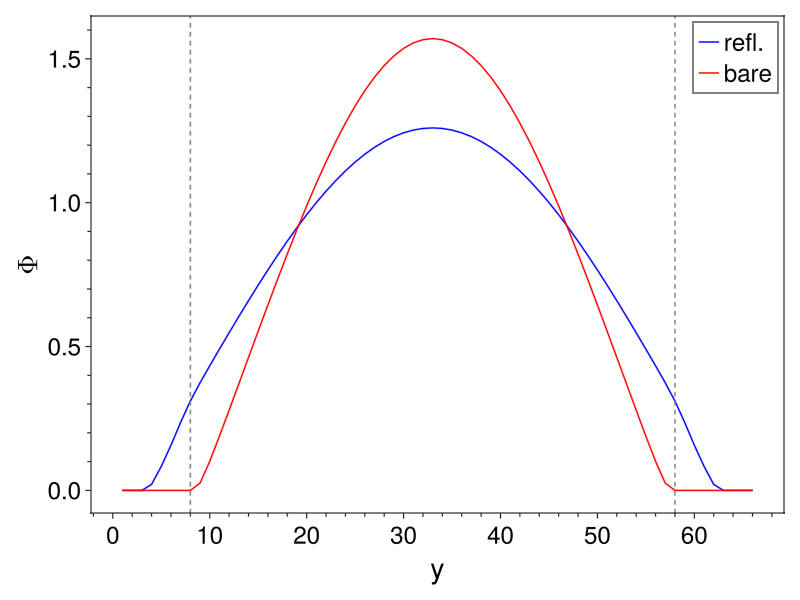

In [30]:

x0 = round(Int, N/2)
fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1]; xlabel="y", ylabel=L"\Phi")
lines!(ax, F1[x0, :], label="refl.", color=:blue)
lines!(ax, F2[x0, :], label="bare", color=:red)
vlines!(ax, [x0-Rc, x0+Rc], color=:gray, linestyle=:dash)
axislegend(ax)

@printf("%.3e %.3e\n", sum(F1[x0, x0-Rc:x0+Rc]), sum(F2[x0, x0-Rc:x0+Rc]))

fig

Nasz model reaktora możemy teraz oczywiście dowolnie komplikować (w ramach możliwości obliczeniowych komputera - algorytmy odwracania macierzy mają złożoność $N^2$), wprowadzać różne materiały np. rdzeń o większym i mniejszym wzbogaceniu, pręty kontrolne, siatkę paliwo/moderator itd.